# Using Deep Learning Model to Classify Dog Breeds

In this notebook I am going to show results of applying pre-trained deep learning models to dogs breeds classification. The main goal of the notebook is to see how simple it could be to achive good classification results using "out-of-the-box" models and common training strategies without applying too fancy data transformations or using sophisticated fine-tuning methods.

The dataset is taken from [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data) and contains around ~10K training images (in various resolution).

![Image](assets/header.png)

As a small spoiler, pretrained models shows quite good results even without. And, though it is not enough to achieve state of art results, it allows to classify images with quite good accuracy.

## Imports and Extensions

In [82]:
%load_ext autoreload

In [83]:
%matplotlib inline
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [141]:
import os
import csv
import tempfile
from os import listdir
from io import StringIO
from pathlib import Path
from itertools import islice
from os.path import join, abspath
from collections import namedtuple

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import load_model

from sklearn.metrics import log_loss
from sklearn.externals import joblib
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold

from swissknife.config import notebook_logger
from swissknife.utils import calculate_layout
from swissknife.files import FilesStream, SavingFolder
from swissknife.transform import GeneratorPipeline
from swissknife.kaggle.api import ClassifierSubmission
from swissknife.kaggle.datasets import KaggleClassifiedImagesSource, KaggleTestImagesIterator

# File paths from local folder
from basedir import TRAIN_IMAGES, VALID_IMAGES, TEST_IMAGES, LABELS_FILE

In [5]:
log = notebook_logger()

---
## Dataset Overview

Though the main purpose of this post to show power of pretrained models on ImageNet like datasets, it is a good idea to anaylize dataset a bit before starting to build any machine learning pipeline.

> Note that testing data _shouldn't be touched_ during this process. All statistics computations, validation and plots should be performed only on training subset.

Analysed dataset consists of two folders with images, `train` and `test`, and file with labels which maps file name to class, represeted by that file. Let's traverse dataset directories to get lists of available images and parse dataset labels into dictionary which allow to convert image ID into its class:

In [6]:
def list_files(folder):
    return [join(folder, filename) for filename in listdir(folder)]

In [7]:
def read_labels(labels_path):
    """Reads dataset labels from the labels file."""
    with open(labels_path) as fp:
        reader = csv.DictReader(fp)
        labels = {row['id']: row['breed'] for row in reader}
        log.info('Number of unique classes: %d', len(set(labels.values())))
    return labels

In [8]:
train_files = list_files(TRAIN_IMAGES)
valid_files = list_files(VALID_IMAGES)
labels = read_labels(LABELS_FILE)

Number of unique classes: 120


In [9]:
len(train_files)

9200

In [10]:
len(valid_files)

1022

Next, let's create a couple of utilities to present images in convenient format. Each image file should be converted into array of bytes to be plotted with `matplotlib` library. Also, that would be helpful to take small preview of dataset in compact form. The following functions help to achive these goals:

In [11]:
def read_image(filename, labels, dtype=np.uint8):
    """Returns an image and it's class using provided filename."""
    
    path = Path(filename)
    image = plt.imread(path).astype(dtype)
    return image, labels[path.stem]

In [12]:
def read_images(files, labels):    
    """Reads a list of images alongside with their labels using provided ID numbers."""
    
    image_label_pairs = [read_image(file, labels) for file in files]
    images, labels = list(zip(*image_label_pairs))
    return images, labels

In [18]:
def show_images(dataset, labels, preview_size=16, 
                plot_title='Images Grid', thumbnail_size=None,
                tight=False, figsize=(10, 10), n_cols=4):
    """Plots a group of dataset images alongside with their labels
    organized into grid,
    
    Args:
        dataset: List of images (numpy arrays).
        labels: List of labels (strings).
        preview_size: Number of images taken from dataset to be plotted.
        title: Title of generated grid.
        figsize: Tuple with canvas size (n, m).
        n_cols: Number of columns in grid.
    
    """
    grid_size = calculate_layout(preview_size, n_cols=n_cols)
    f, axes = plt.subplots(*grid_size, figsize=figsize)
    
    axes = axes.flatten()            
    sample_subset = islice(zip(dataset, labels), preview_size)
    
    for ax, (image, title) in zip(axes, sample_subset):
        if thumbnail_size is not None:
            pil_image = Image.fromarray(image).resize(thumbnail_size)        
            image = np.array(pil_image)
        ax.imshow(image.astype(np.uint8))        
        title = title.replace('_', ' ').title()
        ax.set_title(title, fontsize=16)
        ax.axis('off')
        
    f.suptitle(plot_title, fontsize=20)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])  # or: f.subplots_adjust(top=0.90)
    return f    

First, plotting a preview of training samples and labels:

In [19]:
# Nubmer of images to be shown
preview_size = 20

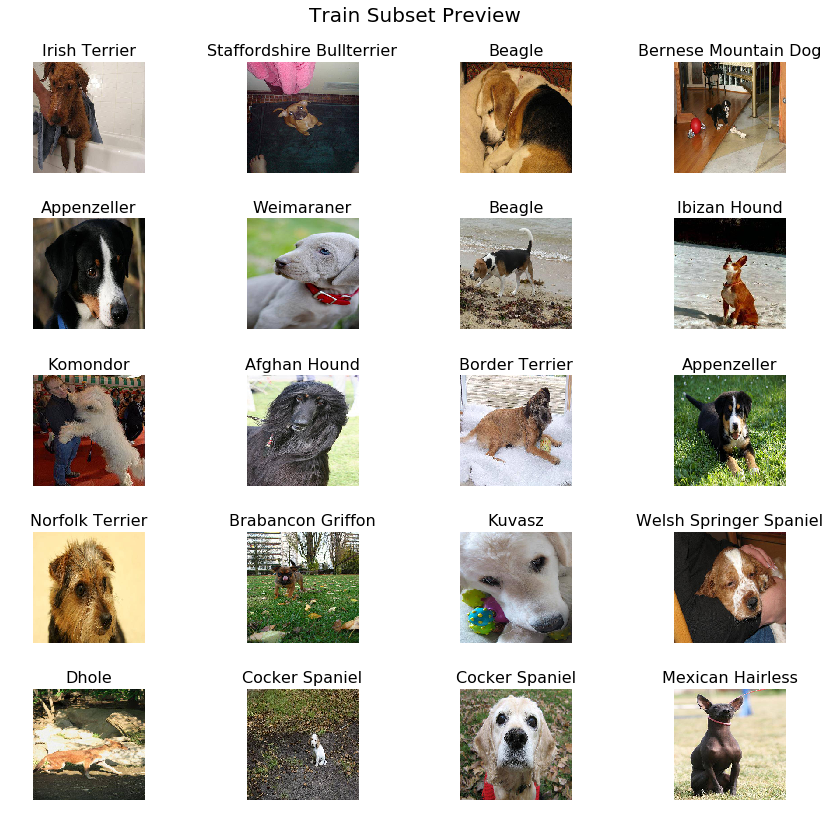

In [20]:
# Take a sample from train data
_ = show_images(*read_images(train_files[:preview_size], labels),
                preview_size=preview_size,
                plot_title='Train Subset Preview',
                thumbnail_size=(256, 256),
                figsize=(12, 12))

Next, doing the same for validation samples:

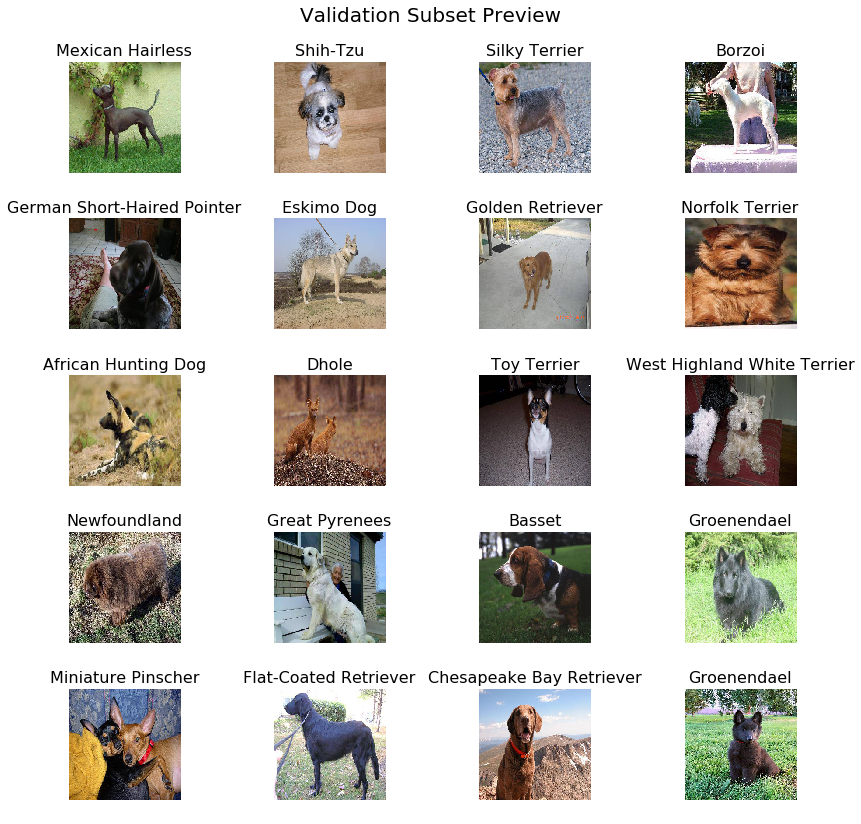

In [21]:
_ = show_images(*read_images(valid_files[:preview_size], labels),
                preview_size=preview_size,
                plot_title='Validation Subset Preview',
                thumbnail_size=(256, 256),
                figsize=(12, 12))

It seems that, generally speaking, images have different resolution, zoom, could have more then one dog depicted on them and were taken in various lighting conditions. 

And what about images classes? How are they distributed? For this purpose a histogram of classes could be created to see if there is any bias:

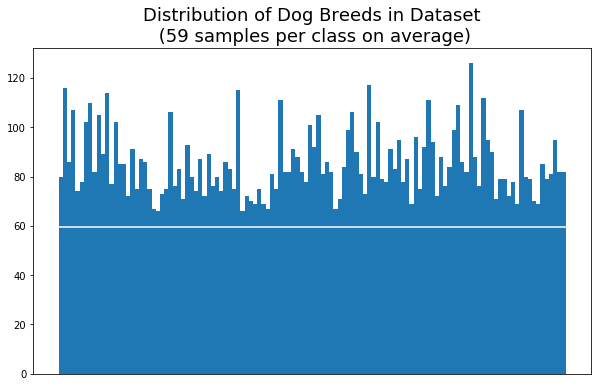

In [23]:
encoder = LabelEncoder()
breeds_encoded = encoder.fit_transform(list(labels.values()))
n_classes = len(encoder.classes_)
mean = np.mean(breeds_encoded)
title = 'Distribution of Dog Breeds in Dataset\n (%2.0f samples per class on average)' % mean

f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xticks([])
ax.hlines(mean, 0, n_classes - 1, color='white')
ax.set_title(title, fontsize=18)
_ = ax.hist(breeds_encoded, bins=n_classes)

Classes are more or less balanced, as historgram shows, with `59` sampler per class on average.

---
## Bootstrapped SGD using Bottleneck Features

One of the most straightforward strategies to apply pretrained deep learning models is to use them as **feature extractors**. Before modern neural architectures were developed, image features were extracted using manually crafted filters. Nowadays it is possible to derive features automatically, from data.

Schematically, a deep learning classifier could be represented as a sequence of blocks, transforming image representation from raw pixels into more and more abstract features like edges, contours, an so on. 

![Deep Model](assets/deep.png)
_Picture 1. Bottleneck Features_

As it is shown on the picture, deep learning model without top layers generates a set of high level abstract features for each shown image. These high level representations are called **bottleneck features**, i.e. a hidden layer activations taken from the model right before feeding them into dense layers. These abstract features, automatically infered by model, could be used then with any "classical" machine learning algorithm to predict targets.

In this section we're going to extract image features using following pretrained deep learning models:
* InceptionV3
* InceptionResNetV2
* Xception

Then, extractred features will be used to train a boosted version SGD classifier and to validate its performance.


### Feature Extractor
The following class called `FeaturesExtractor` is a simple wrapper build on top of functions taken from `keras.applications` module. It creates deep model without top layer, loads pretrained weights and feeds training images into model, saving generated bottleneck features onto disk:

In [36]:
class FeaturesExtractor:
    """Runs pretrained model without top layers on dataset and saves generated
    bottleneck features onto disk.
    """
    def __init__(self, build_fn, preprocess_fn, source,
                 target_size=(299, 299, 3), batch_size=128):        
        
        self.build_fn = build_fn
        self.preprocess_fn = preprocess_fn
        self.source = source
        self.target_size = target_size
        self.batch_size = batch_size
        
    def __call__(self, folder, filename, pool='avg'):
        model = self.build_fn(weights='imagenet', include_top=False, pooling=pool)
        stream = self.source(
            folder=folder, target_size=self.target_size,
            batch_size=self.batch_size, infinite=False)
        
        batches = []
        with tqdm.tqdm_notebook(total=stream.steps_per_epoch) as bar:
            for x_batch, y_batch in stream:
                x_preprocessed = self.preprocess_fn(x_batch)
                batch = model.predict_on_batch(x_preprocessed)
                batches.append(batch)
                bar.update(1)
                
        all_features = np.vstack(batches)
        np.save(filename, all_features)
        return filename

A group of helper functions defined below will help to run feature extractor, validate number of generatated samples and save results onto disk. Then these features will be used as predictors to train SGD classfier:

In [33]:
def extract_features(extractor, folder, filename, size):
    path = extractor(folder, filename)
    features = np.load(path)
    assert len(features) == size
    return path


def extract_train_features(features_extractor, model_name):
    filename = '%s_train_features.npy' % model_name
    return extract_features(features_extractor, TRAIN_IMAGES, filename, size=9200)


def extract_valid_features(features_extractor, model_name):
    filename = '%s_valid_features.npy' % model_name
    return extract_features(features_extractor, VALID_IMAGES, filename, size=1022)

Also, as soon as the dataset is too large to be uploaded into memory at once, a special class called `KaggleClassifiedImagesSource` from `swissknife` package (which was written to clean up my notebooks code and factor out common functionality) is used to build training samples generator. This class accepts path to labels file and a name of column in this file which contains verbose labels names:

In [26]:
source = KaggleClassifiedImagesSource(LABELS_FILE, 'breed')

Next we're going to use this instance to create a generator accepted by Keras model's `train_generator` method like it's shown below:
```Python
generator = source(folder=folder,
                   target_size=target_size,
                   batch_size=batch_size
                   infinite=False)
                   
model.train_generator(generator, steps=generator.steps_per_epoch)
```

I.e. we provide a path to folder with images and the generator will gradually read images from disk on demand when samples asked by training method.

The reason why `KaggleClassifiedImagesSource` is used as factory instead of being used as generator itself and why folder name and samples yielding parameters should be provided in additional call instead of using `__init__` is that we are going to use two different generators during training process: one for traning and one for validation. Therefore, despite of having same set of target labels, we need two different streams of images.

Also, we need targets to train bottleneck classfier. As soon as targets do not occupy too much space, they could be directly loaded into memory:

In [27]:
def create_targets(source, folder):
    """Converts file paths into target labels."""
    labels = [
        one_hot.argmax()
        for one_hot in (
            source.identifier_to_label[Path(filename).stem]
            for filename in os.listdir(folder))]
    return np.asarray(labels)

In [28]:
train_labels = create_targets(source, TRAIN_IMAGES)
valid_labels = create_targets(source, VALID_IMAGES)

### Boosted SGD Classifier

[Stochastic Gradient Descent](http://scikit-learn.org/stable/modules/sgd.html#sgd) (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions. In our case we would like to choose a **logistic regression** classifier to predict dogs breeds.

To make training process more stable and repeatble, we're going to extend SGD with **bagging**, an approach that trains an _ensemble_ of SGD classifiers on different subsets of training data and gives a final prediction by averaging responses from separate estimators. The following picture schematically shows the idea. (Note that in our case we not only splitting original dataset into subsets, but also taking different subsets of features to train each classifier):

![voting](assets/voting.png)

Also, we're going to apply _varience threshold_ to features extract by deep learning networks. The reason why we need this preprocessing step is that generated feature vectors are usually quite sparse - many of their elements are close or equal to zero.

> **Note:** Parameters for classifier were taken after a few runs with different values. Ones that have shown the best results were kept. More "educated" approach would be to run a [grid](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [random](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) search.

In [29]:
def sgd(x_train, y_train, x_valid, y_valid, variance_threshold=0.1):    
    threshold = VarianceThreshold(variance_threshold)
        
    sgd_classifier = SGDClassifier(
        alpha=1./len(x_train),
        class_weight='balanced',
        loss='log', penalty='elasticnet', 
        fit_intercept=False, tol=0.001, n_jobs=-1)
    
    bagging = BaggingClassifier(
        base_estimator=sgd_classifier,
        bootstrap_features=True,
        n_jobs=-1, max_samples=0.5, max_features=0.5)    
    
    x_thresh = threshold.fit_transform(x_train)
    bagging.fit(x_thresh, y_train)
    train_metrics = build_metrics(bagging, x_thresh, y_train)

    x_thresh = threshold.transform(x_valid)
    valid_metrics = build_metrics(bagging, x_thresh, y_valid)

    return bagging, train_metrics, valid_metrics    


def build_metrics(model, X, y):
    probs = model.predict_proba(X)
    preds = np.argmax(probs, axis=1)
    metrics = dict(
        probs=probs,
        preds=preds,
        loss=log_loss(y, probs),
        accuracy=np.mean(preds == y))
    return namedtuple('Predictions', metrics.keys())(**metrics)    

Now when all preparations have done, we can start classifier training on features extracted with pretrained models.

### InceptionV3 Features

The first model selected to generate bottleneck features is [InceptionV3](https://github.com/keras-team/keras/blob/master/keras/applications/inception_v3.py) architecture.

In [37]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

extractor = FeaturesExtractor(
    build_fn=InceptionV3,
    preprocess_fn=preprocess_input,
    source=source)

In [38]:
extract_train_features(extractor, 'inception')

HBox(children=(IntProgress(value=0, max=72), HTML(value='')))

'inception_train_features.npy'

In [39]:
extract_valid_features(extractor, 'inception')

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

'inception_valid_features.npy'

In [40]:
train_features = np.load('inception_train_features.npy')
valid_features = np.load('inception_valid_features.npy')

model, train, valid = sgd(
    x_train=train_features, 
    y_train=train_labels,
    x_valid=valid_features, 
    y_valid=valid_labels,
    variance_threshold=0.1)

print(f'Train: loss {train.loss:2.6f} - acc: {train.accuracy:2.2%}')
print(f'Valid: loss {valid.loss:2.6f} - acc: {valid.accuracy:2.2%}')

Train: loss 0.317071 - acc: 94.02%
Valid: loss 0.471370 - acc: 88.55%


Not bad! Pretrained model shows quite good validation accuracy out of the box, taking into account that training dataset contains 120 classes. Let's try another architecture.

### Xception Features

Now it is turn for [Xception](https://github.com/keras-team/keras/blob/master/keras/applications/xception.py) model:

In [54]:
from keras.applications.xception import Xception, preprocess_input

extractor = FeaturesExtractor(
    build_fn=Xception,
    preprocess_fn=preprocess_input,
    stream_factory=source)

In [55]:
extract_train_features(extractor, 'xception')

72/72 [==============================] - 74s 1s/step


'xception_train_features.npy'

In [56]:
extract_valid_features(extractor, 'xception')

8/8 [==============================] - 9s 1s/step


'xception_valid_features.npy'

In [63]:
train_features = np.load('xception_train_features.npy')
valid_features = np.load('xception_valid_features.npy')

model, train, valid = sgd(
    x_train=train_features, 
    y_train=train_labels,
    x_valid=valid_features, 
    y_valid=valid_labels,
    variance_threshold=0.01)

print(f'Train: loss {train.loss:2.6f} - acc: {train.accuracy:2.2%}')
print(f'Valid: loss {valid.loss:2.6f} - acc: {valid.accuracy:2.2%}')

Train: loss 0.284703 - acc: 95.40%
Valid: loss 0.410348 - acc: 90.80%


The model shows even better results on both validation and training data. Note that `varience_threshold` parameter was chagned because with value of `0.1` selected for the previous model **all generatered features** are excluded from training. Therefore we can say that the magnitude of variance of Xception features is small then in previous model.

### InceptionResNetV2

The last model we are going to try is [InceptionResNetV2](https://github.com/keras-team/keras/blob/master/keras/applications/inception_resnet_v2.py).

In [67]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

extractor = FeaturesExtractor(
    build_fn=InceptionResNetV2,
    preprocess_fn=preprocess_input,
    stream_factory=source)

In [68]:
extract_train_features(extractor, 'inception_resnet')

72/72 [==============================] - 82s 1s/step


'inception_resnet_train_features.npy'

In [69]:
extract_valid_features(extractor, 'inception_resnet')

8/8 [==============================] - 12s 1s/step


'inception_resnet_valid_features.npy'

In [73]:
train_features = np.load('inception_resnet_train_features.npy')
valid_features = np.load('inception_resnet_valid_features.npy')

model, train, valid = sgd(
    x_train=train_features, 
    y_train=train_labels,
    x_valid=valid_features, 
    y_valid=valid_labels,
    variance_threshold=0.001)

print(f'Train: loss {train.loss:2.6f} - acc: {train.accuracy:2.2%}')
print(f'Valid: loss {valid.loss:2.6f} - acc: {valid.accuracy:2.2%}')

Train: loss 0.198887 - acc: 94.53%
Valid: loss 0.302672 - acc: 92.47%


The architecture shows even better results in comparison with previous ones, achieving validation accuracy of `92.47%`. But how good our validation accuracy reflects results we could get on Kaggle's test dataset? Let's check it in next section.


### Submitting Best Architecture Results

As we've seen above, the best results were shown with **InceptionResNetV2**. We're going to reload extracted features and train model again, but with train and valid features concatenated together.

In [11]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input   

In [12]:
train_features = np.load('inception_resnet_train_features.npy')
valid_features = np.load('inception_resnet_valid_features.npy')

source = KaggleClassifiedImagesSource(LABELS_FILE, 'breed')
train_labels = create_targets(source, TRAIN_IMAGES)
valid_labels = create_targets(source, VALID_IMAGES)

In [13]:
X = np.vstack([train_features, valid_features])
y = np.hstack([train_labels, valid_labels])

In [14]:
X.shape

(10222, 1536)

In [15]:
y.shape

(10222,)

In [16]:
threshold = VarianceThreshold(0.001)
        
sgd_classifier = SGDClassifier(
    alpha=1./X.shape[0],
    class_weight='balanced',
    loss='log', penalty='elasticnet', 
    fit_intercept=False, tol=0.001, n_jobs=-1)
    
bagging = BaggingClassifier(
    base_estimator=sgd_classifier,
    n_estimators=100,
    bootstrap_features=True,
    n_jobs=-1, max_samples=0.5, max_features=0.5)

bagging.fit(threshold.fit_transform(X), y)

BaggingClassifier(base_estimator=SGDClassifier(alpha=9.782821365681862e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=False,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_jobs=-1, penalty='elasticnet', power_t=0.5,
       random_state=None, shuffle=True, tol=0.001, verbose=0,
       warm_start=False),
         bootstrap=True, bootstrap_features=True, max_features=0.5,
         max_samples=0.5, n_estimators=100, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [18]:
joblib.dump(bagging, 'sgd_bagging.pickle')

['sgd_bagging.pickle']

In [19]:
bagging = joblib.load('sgd_bagging.pickle')

In [20]:
extractor = InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')

In [22]:
threshold = VarianceThreshold(0.001).fit(X)

test_images = KaggleTestImagesIterator(
    test_folder=TEST_IMAGES,
    target_size=(299, 299, 3), 
    batch_size=128,
    with_identifiers=True)

file_preds = {}
for images, identifiers in test_images:
    features = extractor.predict(preprocess_input(images))
    features_selected = threshold.transform(features)
    preds = bagging.predict_proba(features_selected)
    file_preds.update(dict(zip(identifiers, preds)))

In [23]:
classes = source.binarizer.classes_.tolist()

In [25]:
submission = ClassifierSubmission(log=log)
_, filename = tempfile.mkstemp(suffix='.csv')
submission.create(classes, file_preds, output=filename)

In [27]:
result = submission.submit(filename, 'dog-breed-identification', message='Bagging with SGD')

Sending submission...
Successfully submitted to Dog Breed Identification
Evaluating results...


In [28]:
print(f'Public score: {result["publicScore"]:2.6f}')

Public score: 0.307820


We can see that loss value achieved on validation data approximates loss on public test dataset very well.

Boosted SGD classfier has shown quite good results on dogs breeds dataset. But can we do better? In next section we're going to check performance of deep models with re-trained top layer and data augmentation.

---
## Pretrained Models Fine-tuning

Bottleneck features training showed that extracted features allows to achieve good prediction results. But could we improve result with **fine-tunining** orignal models re-training top layers from scratch and applying data augmentation techniques?

Briefly speaking, the purpose of fine-tuning process is to adjust pretrained model to your data. Because in most cases, the model you're going to re-use was trained on dataset with different number of classes. Therefore, you need at least replace a top classifying layer. Other layers could be "locked", or _frozen_, i.e. during traning new top layer their weights do not receive updates. 

<p align="center"><img src="assets/finetuning.png"/></p>

Actully, the process of training new top layer is not too different from previous approach of using network as a feature extractor. We just use a different type of classifier (single layer perceptron). The only difference is aforementioned **data augmentation**. Each fine-tuned network was trained using slightly modified copies of images from original dataset (a bit rotated, zoomed in, etc.).

### Chosen Models and Training Process

A group of models taken from Keras library was trained on augmented dataset during fixed number of training epochs. Training process takes time and was performed outside of this notebook. So in this section we're going to restore trained models and their training history to see how well they perform on analysed dataset.

The following models were selected to be fine-tuned on dog breeds datasets:
* ResNet50
* InceptionV3
* Xception
* InceptionResNetV2

Each model was trained during **100 epochs** with early stopping and with **128 samples per bach** using same opmitizer - Stochastic Gradient Descent with Nesterov momentum enabled:

```python
from keras.optimizers import SGD
sgd = SGD(lr=0.001, momentum=0.99, nesterov=True)
```

The following augmentation paramers were chosen:
```python
from keras.preprocessing.image import ImageDataGenerator
transformer = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    vertical_flip=False,
    horizontal_flip=True)
```

Function `run_model` is used to perform the following sequence of steps:
1. Restores model from disk
2. Applies model to validation data and reports results
3. Applies model to testing data and builds predictions dictionary

In [30]:
def run_model(path, preprocess, target_size):
    """Runs fine-tuned model with pre-trained weights on validation
    and test data, reporting validation results.
    
    Args:
        path: Path to folder with cached model.
        preprocess: Function applied to images before feeding into model. 
            Should be same preprocessing function which was applied to samples
            during model's training.
        target_size: Size to rescale validation and testing images. 
            Should be same value which was used during training process.
    
    Returns:
        classes, file_preds: The list of classes in dataset and dictionary 
            with predictions arrays (one array per image). 
    
    """
    
    
    def as_generator(func):
    """
    Wraps function with infinite generator loop.
    """
    while True:
        x, y = yield
        transformed = func(x)
        yield transformed, y
    
    
    log.info('Restoring model: %s', path)
    saved = SavingFolder(path)
    model = load_model(saved.best_checkpoint())
    
    source = KaggleClassifiedImagesSource(LABELS_FILE, 'breed')
    train_labels = create_targets(source, TRAIN_IMAGES)
    valid_labels = create_targets(source, VALID_IMAGES)
    
    validation_data = source(
        VALID_IMAGES, 
        target_size=target_size,
        batch_size=128,
        infinite=False)

    pipeline = GeneratorPipeline(validation_data, as_generator(preprocess))
    log.info('Running restored model on validation data...')
    probs = model.predict_generator(
        generator=pipeline,
        steps=validation_data.steps_per_epoch)
    
    preds = probs.argmax(axis=1)
    val_loss = log_loss(valid_labels, probs)
    accuracy = np.mean(preds == valid_labels)
    log.info(f'Validation: loss {val_loss:2.6f} - accuracy {accuracy:2.2%}')
    
    test_images = KaggleTestImagesIterator(
        test_folder=TEST_IMAGES,
        target_size=target_size, 
        batch_size=128,
        with_identifiers=True)

    file_preds = {}
    log.info('Running restored model on test set...')
    for images, identifiers in test_images:
        preprocessed = preprocess(images)
        preds = model.predict_on_batch(preprocessed)
        file_preds.update(dict(zip(identifiers, preds)))
    
    classes = source.binarizer.classes_.tolist()
    return classes, file_preds

### Evaluation and Submissions

On my local machine, the following folders with trained models were created:

In [24]:
MODELS = !ls -1 $TF_OUTPUT_DIR/models/ | grep -E "*e100$"

In [25]:
MODELS

['densenet_sgd_m099_avg_bs128_e100',
 'inception3_sgd_m099_bs128_e100',
 'inception_resnet_sgd_m099_bs128_e100',
 'nasnet_sgd_m099_avg_bs128_e100',
 'resnet50_top_only_sgd_m099_bs128_e100',
 'xception_sgd_m099_avg_bs128_e100']

Let's restore each of models and see validate their performance. Next helper function runs model and submits testing results to Kaggle:

In [33]:
def make_kaggle_submission(
    path_to_model,
    preprocess_input,
    target_size,
    message):
     
    classes, predictions = run_model(
        path=path_to_model,
        preprocess=preprocess_input,
        target_size=target_size)
        
    submission = ClassifierSubmission(log=log)
    _, filename = tempfile.mkstemp(suffix='.csv')
    submission.create(classes, predictions, output=filename)
    
    result = submission.submit(filename, 'dog-breed-identification', message=message)
    log.info('Kaggle public score: %2.6f', result['publicScore'])

In [34]:
from keras.applications import resnet50

make_kaggle_submission(
    path_to_model='resnet50_top_only_sgd_m099_bs128_e100',
    preprocess_input=resnet50.preprocess_input,
    target_size=(224, 224, 3),
    message='ResNet50 Fine-Tuning')

Restoring model: resnet50_top_only_sgd_m099_bs128_e100
Running restored model on validation data...
Validation: loss 0.923906 - accuracy 73.39%
Running restored model on test set...
Sending submission...
Successfully submitted to Dog Breed Identification
Evaluating results...
Kaggle public score: 0.940900


In [35]:
from keras.applications import inception_v3

make_kaggle_submission(
    path_to_model='inception3_sgd_m099_bs128_e100',
    preprocess_input=inception_v3.preprocess_input,
    target_size=(299, 299, 3),
    message='InceptionV3 Fine-Tuning')

Restoring model: inception3_sgd_m099_bs128_e100
Running restored model on validation data...
Validation: loss 0.344614 - accuracy 88.26%
Running restored model on test set...
Sending submission...
Successfully submitted to Dog Breed Identification
Evaluating results...
Kaggle public score: 0.343280


In [45]:
from keras.applications import xception

make_kaggle_submission(
    path_to_model='xception_sgd_m099_avg_bs128_e100',
    preprocess_input=xception.preprocess_input,
    target_size=(299, 299, 3),
    message='Xception Fine-Tuning')

Restoring model: xception_sgd_m099_avg_bs128_e100
Running restored model on validation data...
Validation: loss 0.313156 - accuracy 90.31%
Running restored model on test set...
Sending submission...
Successfully submitted to Dog Breed Identification
Evaluating results...
Kaggle public score: 0.341680


In [46]:
from keras.applications import inception_resnet_v2

make_kaggle_submission(
    path_to_model='inception_resnet_sgd_m099_bs128_e100',
    preprocess_input=inception_resnet_v2.preprocess_input,
    target_size=(299, 299, 3),
    message='InceptionResNetV2 Fine-Tuning')

Restoring model: inception_resnet_sgd_m099_bs128_e100
Running restored model on validation data...
Validation: loss 0.256078 - accuracy 91.59%
Running restored model on test set...
Sending submission...
Successfully submitted to Dog Breed Identification
Evaluating results...
Kaggle public score: 0.280520


## Appendix: Visualizing Predictions

In [1]:
import os
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.applications import inception_resnet_v2

from swissknife.plotting import plot_predictions
from swissknife.images import FallbackImageLoader
from swissknife.files import SavingFolder
from swissknife.kaggle.datasets import KaggleClassifiedImagesSource

# File paths from local folder
from basedir import LABELS_FILE

/home/ck/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
loader = FallbackImageLoader()

In [3]:
IMAGES_ROOT = join(os.getcwd(), 'test_images/')
images = [join(IMAGES_ROOT, name) for name in (
    'dog1.png',
    'dog2.png',
    'dog3.png',
    'cat1.png'
)]

In [4]:
def load_to_predict(path):
    return loader(path, target_size=(299, 299, 3))

def load_to_display(path):
    return loader(path).astype(np.uint8)

In [5]:
saved = SavingFolder('inception_resnet_sgd_m099_bs128_e100')
model = load_model(saved.best_checkpoint())

In [6]:
source = KaggleClassifiedImagesSource(LABELS_FILE, 'breed')

In [7]:
batch = np.asarray([load_to_predict(path) for path in images])
batch = inception_resnet_v2.preprocess_input(batch)
batch.shape

(4, 299, 299, 3)

In [8]:
preds = model.predict_on_batch(batch)

In [9]:
indexes = np.argsort(-preds, axis=1)[:, :5]

In [10]:
labels = [source.integer_to_verbose(i) for i in indexes]

In [11]:
f, axes = plt.subplots(4, 1, figsize=(16, 20))
axes = axes.flatten()
for i, (path, labels, ax) in enumerate(zip(images, indexes, axes)):
    probs = preds[i][labels].tolist()
    verbose = [source.integer_to_verbose(i).replace('_', ' ').title() for i in labels]
    weights = dict(zip(verbose, probs))
    image = load_to_display(path)
    plot_predictions(image, weights, labels_font_size=16, sort_by_probability=True, ax=ax)

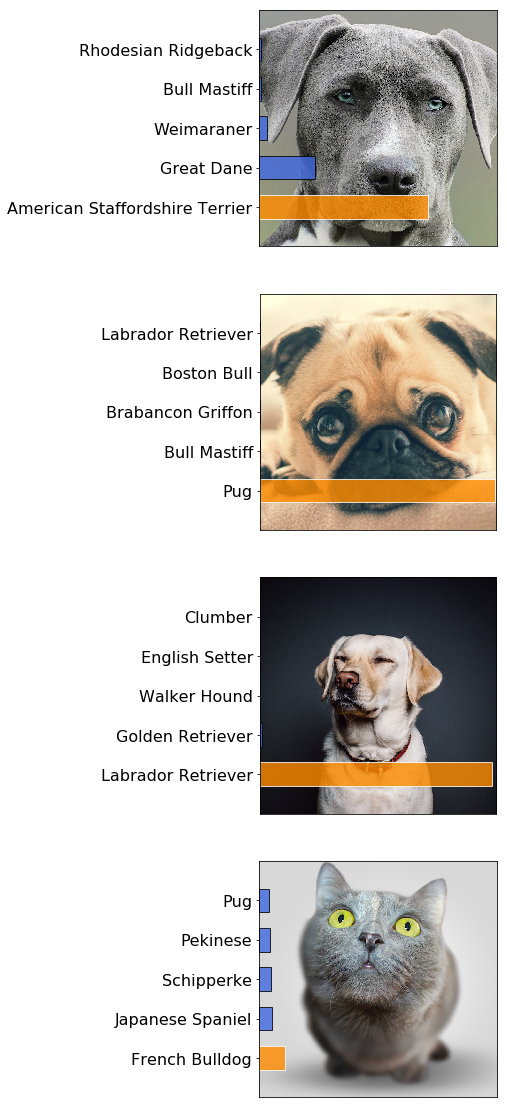

In [12]:
plt.show()